In [32]:
# std libraries
import os
import tarfile
import urllib
from zipfile import ZipFile
import math

# data processing libraries
import numpy as np
import pandas as pd

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# **What Price Should You Charge (per night)?**
## Let's build a model that will predict what nightly price you should set for your new listing.

### Getting the Data

We'll be using the [AirBnb Seattle Open Data](https://www.kaggle.com/airbnb/seattle/data) from [kaggle](https://www.kaggle.com) to answer our questions.  
To do that, you we will need a kaggle account and an API key to download the data.  
A tutorial on how to setup your API key can be found on the [Kaggle Public API Documentation](https://www.kaggle.com/docs/api).  
Check it out and come back once it is done.

In [2]:
# install kaggle package
!pip install kaggle

Now we just download the dataset using the API command.

In [3]:
# you need a kaggle API key to run this command
!kaggle datasets download -d airbnb/seattle

seattle.zip: Skipping, found more recently modified local copy (use --force to force download)


And extract it in the local folder called 'data'.

In [4]:
dir_path = os.path.dirname(os.getcwd()) # get current working directory
zip_file_path = os.path.join(dir_path, './mediumblog/seattle.zip')
extract_dir_path = os.path.join(dir_path, './mediumblog/data/seattle/')

with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir_path)

First we'll take a look at the listings data.

In [5]:
seattle_listings = pd.read_csv('./data/seattle/listings.csv')
print("Columns: {}".format(seattle_listings.shape[1]))
print("Rows: {}".format(seattle_listings.shape[0]))
seattle_listings.sample(5)

Columns: 92
Rows: 3818


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
670,4370312,https://www.airbnb.com/rooms/4370312,20160104002432,2016-01-04,Comfy Craftsman with Mountain View,Charming one-bedroom apartment with craftsman ...,Your hosts are fellow Airbnb travelers and we'...,Charming one-bedroom apartment with craftsman ...,none,"Our neighborhood, Madrona, is quiet and quaint...",...,10.0,f,NaN,WASHINGTON,t,moderate,f,f,1,4.00
3478,146301,https://www.airbnb.com/rooms/146301,20160104002432,2016-01-04,"West Seattle, The Full Moon Cottage","Up to six guests may share our urban cottage, ...",This two bedroom house sleeps a maximum of 6 g...,"Up to six guests may share our urban cottage, ...",none,NaN,...,9.0,f,NaN,WASHINGTON,t,strict,f,f,3,0.28
1784,10121329,https://www.airbnb.com/rooms/10121329,20160104002432,2016-01-04,Alki Beach: Work Road Trip,Welcome to my tri-level Harbor Ave home (Which...,I have a top floor open floor plan with a dini...,Welcome to my tri-level Harbor Ave home (Which...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,moderate,t,t,1,NaN
3434,5228066,https://www.airbnb.com/rooms/5228066,20160104002432,2016-01-04,Sunny 2Bdrm/2bath Apartment,Spacious 2 bedroom/2 bathroom apartment next d...,Free WiFi ** Free Street Parking ** Pet Free M...,Spacious 2 bedroom/2 bathroom apartment next d...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,0.21
2880,3396140,https://www.airbnb.com/rooms/3396140,20160104002432,2016-01-04,Middle of it All in Pike/Pine,One room with a queen size bed in my 2 BR apar...,"You're welcome to make some tea, grab a book, ...",One room with a queen size bed in my 2 BR apar...,none,"Centrally-located: restaurants, bars, grocery ...",...,9.0,f,NaN,WASHINGTON,f,moderate,f,f,1,3.88


This dataset has quite a lot of columns, so we need to choose a subset that will be relevant to this analysis.  
I've created a curated list of columns removing anything that relates to technical elements (like 'scrape_id', 'thumbnail_url', etc.),  
irrelevant location columns (like 'street', 'city', 'state', etc.) and other elements that don't help (like 'neighborhood_overview' or 'experiences_offered').  
Here's what remains:

In [6]:
# relevant columns for the analysis
relevant_cols = ['id', 'name', 'description', 'host_since', 'host_response_time', 'host_acceptance_rate', 'host_is_superhost', \
                 'host_listings_count', 'host_total_listings_count', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', \
                 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', \
                 'price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', \
                 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', \
                 'number_of_reviews', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', \
                 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', \
                 'review_scores_value', 'cancellation_policy', 'reviews_per_month']

Before we start any data exploration, we'll sample a test set and put it aside (for final model validation).  
This helps us prevent [data snooping](https://web.ma.utexas.edu/users/mks/statmistakes/datasnooping.html) and overfitting by creating a model biased on the data.

In [7]:
# Set 20% of the dataset aside for final model validation
train_df = seattle_listings[relevant_cols].sample(frac=0.8, random_state=42)
test_df = seattle_listings[relevant_cols].drop(train_df.index)

### **Exploring and Preparing the Data**

Let's take a look at our dataset (we'll only be using 'listings' to begin with) to study each attribute and its characteristics.  
Namely:
- name and type (we'll document the ones that need to be converted)
- % of missing values (and decide which columns to drop and which to impute)
- distribution type (and determine if it requires any transformations)
- noisiness and type of noise of each variable (via histograms, boxplots, etc.)

This will help us identify what cleaning tasks we need to do before we can do any analysis or model building.  
**Note:** from here on out we will be using train_df instead of the full seattle_listings DataFrame.

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054 entries, 2562 to 1384
Data columns (total 46 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            3054 non-null   int64  
 1   name                          3054 non-null   object 
 2   description                   3054 non-null   object 
 3   host_since                    3053 non-null   object 
 4   host_response_time            2640 non-null   object 
 5   host_acceptance_rate          2436 non-null   object 
 6   host_is_superhost             3053 non-null   object 
 7   host_listings_count           3053 non-null   float64
 8   host_total_listings_count     3053 non-null   float64
 9   neighbourhood_cleansed        3054 non-null   object 
 10  neighbourhood_group_cleansed  3054 non-null   object 
 11  latitude                      3054 non-null   float64
 12  longitude                     3054 non-null   float64
 13  

#### Type Conversion

Just by looking at the dataset info we see we have a few missing values here and there, and quite a few mistyped columns.  
Columns that should be dates:
 - 'host_since', 'first_review', 'last_review'  
 
Columns that should be numbers: 
 - as price: 'price', 'weekly_price', 'monthly_price', 'securing_deposit', 'cleaning_fee', 'extra_people'
 - as percentages: 'host_acceptance_rate'

In [9]:
# Converting date columns to date
date_cols = ['host_since', 'first_review', 'last_review']
for date_col in date_cols:
    train_df[date_col] = pd.to_datetime(train_df[date_col], errors='ignore') # because we have missing values

In [10]:
# Converting price columns to float
def clean_price(col):
    no_comma_price = col.str.replace(',', '')
    clean_price = no_comma_price.str.replace('$', '')
    return clean_price

price_cols = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']

train_df[price_cols] = train_df[price_cols].apply(clean_price, axis=0) # remove commas and currency symbols from price strings
train_df[price_cols] = train_df[price_cols].astype(float) # convert price values to float

In [11]:
# Rename price columns to indicat _usd in name
new_price_cols = []
for price_col in price_cols:
    new_col_name = price_col + '_usd'
    new_price_cols.append(new_col_name)

rename_dict = dict()
for old_name, new_name in zip(price_cols, new_price_cols):
    rename_dict[old_name] = new_name

train_df.rename(columns=rename_dict, inplace=True)

In [12]:
# Converting percentage columns to float
def clean_perc(col):
    no_perc_rate = col.str.replace('%', '')
    return no_perc_rate

rate_cols = ['host_acceptance_rate']

train_df[rate_cols] = train_df[rate_cols].apply(clean_perc, axis=0) # remove commas and currency symbols from price strings
train_df[rate_cols] = train_df[rate_cols].astype(float) / 100 # divide by 100 to get values bewtween 0 and 1

#### Missing Values
Next we'll take a look at missing value columns to decide how we handle them.  
Generally, we can either impute the values or remove the data altogether (either entire row or entire column), but there is also a third option:  
If we think missing values in a column have some meaning, you can create a new column to indicate if your subject column has any missing values.

In [13]:
# create series of missing percentages
train_missing_vals = (train_df.isnull().sum() / train_df.shape[0]).sort_values(ascending=False)
train_missing_vals[train_missing_vals > 0] * 100

monthly_price_usd              60.772757
security_deposit_usd           50.654879
weekly_price_usd               47.609692
cleaning_fee_usd               26.358874
host_acceptance_rate           20.235756
review_scores_checkin          17.059594
review_scores_accuracy         17.059594
review_scores_value            16.994106
review_scores_location         16.961362
review_scores_cleanliness      16.928618
review_scores_communication    16.863130
review_scores_rating           16.764898
reviews_per_month              16.208251
first_review                   16.208251
last_review                    16.208251
host_response_time             13.555992
bathrooms                       0.491159
bedrooms                        0.130976
host_since                      0.032744
host_is_superhost               0.032744
host_listings_count             0.032744
host_total_listings_count       0.032744
beds                            0.032744
property_type                   0.032744
dtype: float64

It seems that monthly price is missing for most of the observations (probably people don't host for more than a month) so we'll just drop that. Weekly price also has a lot of missing values so we'll drop that as well.  
Security deposit also has more than 50% missing values, but a [quick search](https://www.airbnb.com/help/article/2526/as-a-host-what-should-i-know-about-security-deposits) shows that AirBnb doesn't require one, so most likely missing values reflect listings not requiring one. We'll keep it and insert a boolean column 'has_security_deposit' of 1s and 0s to reflect if a listing requires a security deposit.  
[Same goes for cleaning fee](https://www.smartbnb.io/airbnb-cleaning-fees-heres-everything-you-need-to-know/), which is optional although very common. We'll handle it exactly like security deposit.

In [14]:
no_security_fee = train_df[train_df['security_deposit_usd'] == 0]['security_deposit_usd']
if no_security_fee.empty:
    print("No listings with a $0 security fee.")
else:
    print(no_security_fee.sample(5))

No listings with a $0 security fee.


Indeed if we look for observations with a \$0 security deposit, we will find none.

In [15]:
no_cleaning_fee = train_df[train_df['cleaning_fee_usd'] == 0]['cleaning_fee_usd']
if no_cleaning_fee.empty:
    print("No listings with a $0 cleaning fee.")
else:
    print(no_cleaning_fee.sample(5))

No listings with a $0 cleaning fee.


In [16]:
# check if you will find any number of reviews in any of the obs with missing acceptance rate
train_df[train_df['host_acceptance_rate'].isnull()]['number_of_reviews'].sum()

4481

I was expecting that acceptance rate is null only where number of reviews is missing, meaning they didn't have the chance to accept any guest yet.  
That's not true, so given I don't really think this is very important column, I'll just drop it.

In [17]:
# check if you will find any number of reviews in any of the obs with no subcategory score.
review_cols = ['review_scores_checkin', 'review_scores_accuracy', 'review_scores_value', 'review_scores_location', \
               'review_scores_cleanliness', 'review_scores_communication', 'review_scores_rating']

print("\nCheck for any category reviews in obs. with no reviews at all")
for review_col in review_cols:
    print('reviews where {} is null:'.format(review_col), train_df[train_df['number_of_reviews'].isnull()][review_col].sum(), sep='\t\t')
    
print("\nCheck for no. of reviews in obs. with category reviews")
for review_col in review_cols:
    print('reviews where {} is null:'.format(review_col), train_df[train_df[review_col].isnull()]['number_of_reviews'].sum(), sep='\t\t')


Check for any category reviews in obs. with no reviews at all
reviews where review_scores_checkin is null:		0.0
reviews where review_scores_accuracy is null:		0.0
reviews where review_scores_value is null:		0.0
reviews where review_scores_location is null:		0.0
reviews where review_scores_cleanliness is null:		0.0
reviews where review_scores_communication is null:		0.0
reviews where review_scores_rating is null:		0.0

Check for no. of reviews in obs. with category reviews
reviews where review_scores_checkin is null:		29
reviews where review_scores_accuracy is null:		29
reviews where review_scores_value is null:		27
reviews where review_scores_location is null:		26
reviews where review_scores_cleanliness is null:		23
reviews where review_scores_communication is null:		21
reviews where review_scores_rating is null:		17


So we have no category ratings where the guest didn't leave a review at all, and the above numbers suggest that all other missing category reviews are due to guests not completing them (star reviews are also optional).  
In this case we will impute the values for all of these columns, let's take a look and see if mean or median fits best.

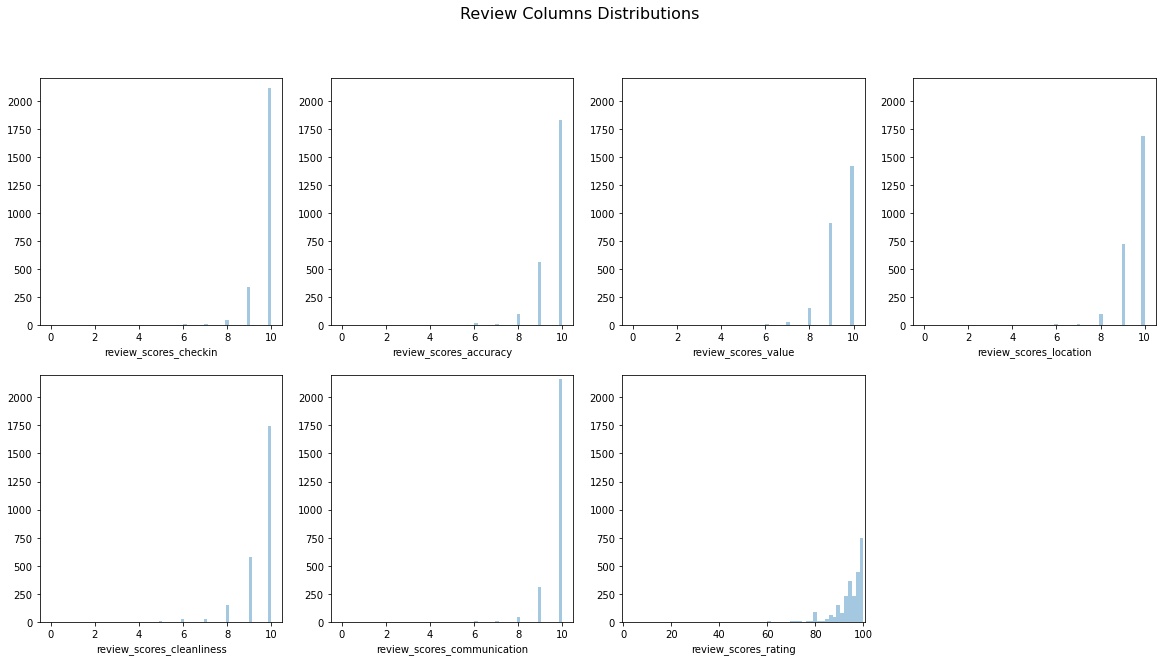

In [18]:
# Draw a grid of review column histograms
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten() # flatten to loop through

fig.suptitle('Review Columns Distributions', fontsize=16)

index = 0
for ax in axs:
    if index < len(review_cols):
        sns.distplot(train_df[review_cols[index]], hist=True, kde=False, label=review_cols[index], ax=ax)
        ax.set_ylim(0, 2200)
        if index == len(review_cols) - 1:
            ax.set_xlim(-0.5, 100.5)
        else:
            ax.set_xlim(-0.5, 10.5)
        index += 1
        
fig.delaxes(axs[-1]) # delete the empty ax
plt.show() # show figures

All review columns are heavily left skewed with very few values below the middle mark.  
There's a great explanation for why that happens in [this article from The Brink](http://www.bu.edu/articles/2015/at-airbnb-where-every-stay-is-above-average/). In short:
> " (...) **when guests and hosts are rating each other — and when the transaction feels more personal**, as it does on Airbnb, or in the case of Uber, the online ridesharing platform — **both parties tend to be more charitabl**e. (...) Reputations are at stake on both sides of the transaction."

Ok, but we still need a way to impute missing values.  
Given the nature of the data, I will impute the median for all review columns to keep them as integers.

In [19]:
train_df[review_cols].describe()

,review_scores_checkin,review_scores_accuracy,review_scores_value,review_scores_location,review_scores_cleanliness,review_scores_communication,review_scores_rating
count,2533.000000,2533.000000,2535.000000,2536.000000,2537.000000,2539.000000,2542.000000
mean,9.782471,9.643901,9.452071,9.601341,9.564052,9.804254,94.575531
std,0.611611,0.698904,0.750671,0.637412,0.794758,0.594735,6.612541
min,2.000000,2.000000,2.000000,4.000000,3.000000,2.000000,20.000000
25%,10.000000,9.000000,9.000000,9.000000,9.000000,10.000000,93.000000
50%,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,96.000000
75%,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,99.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,100.000000


In [20]:
# check if you will find any missing first review dates where number of reviews is NOT null
train_df[~train_df['number_of_reviews'].isnull()]['host_response_time']

2562    within an hour
1425      within a day
2186               NaN
3494    within an hour
3046    within an hour
             ...      
2395      within a day
1996    within an hour
2434    within an hour
1958      within a day
1384      within a day
Name: host_response_time, Length: 3054, dtype: object

In [21]:
response_time_counts = train_df.groupby(['host_response_time']).size().sort_values(ascending=False)
response_time_counts['missing'] = train_df['host_response_time'].isnull().sum()
print("Observations: {}".format(train_df.shape[0]))
print((response_time_counts / train_df.shape[0] * 100))

Observations: 3054
host_response_time
within an hour        44.597250
within a few hours    25.573019
within a day          15.389653
a few days or more     0.884086
missing               13.555992
dtype: float64


This one is tricky, because there is indeed a lot of missing data, and just imputing the most frequent category is not correct - it will tend to over-represent the dominant category.  
Randomly assigning values following the same distribution of categories might work, but it's also not entirely accurate, as the missing data may have a hidden cause.  
We know for one that most of these missing values come from listings which had no reviews yet, but all the other are still unresolved.  
The safest option for now would be to create a flag column to mark rows with missing data.

--- 

We've finally identified all the relevant columns and how to fill in missing data for most of them.  
Let's get to handling this missing data, and afterwards we'll remove the observations still containing missing values.  
This shouldn't affect the end result, as I expect these to make >1% of all values.

In [22]:
# drop columns with missing data
drop_cols = ['monthly_price_usd', 'weekly_price_usd', 'host_acceptance_rate', 'last_review', 'first_review', 'host_since', 'reviews_per_month']
train_df.drop(drop_cols, axis=1, inplace=True)

In [23]:
# create flag columns for features with meaning behind missing data
flag_cols = ['security_deposit_usd', 'cleaning_fee_usd', 'host_response_time']

for col in flag_cols:
    col_flag = col + '_missing_flag'
    train_df[col_flag] = 1 - train_df[col].isnull() * 1 # creates 1's for missing values and 0's for all other

In [24]:
# impute median values
median_cols = ['review_scores_checkin', 'review_scores_accuracy', 'review_scores_value', 'review_scores_location', \
               'review_scores_cleanliness', 'review_scores_communication', 'review_scores_rating', 'bathrooms', \
               'bedrooms', 'beds', 'host_listings_count', 'host_total_listings_count']

# multi column fillna not yet implemented
for col in median_cols:
    train_df[col] = train_df[col].fillna(train_df[col].median())

In [25]:
# impute mode for superhost column
mode_cols = ['host_is_superhost']

for col in mode_cols:
    col_mode = train_df[col].mode().values[0] # for some reason column mode doesn't directly work in fillna
    train_df[col] = train_df[col].fillna(col_mode)

And to finalize, we'll drop all observations (in this case, one) that have missing values for any other column except 'security_deposit_usd', 'cleaning_fee_usd' and 'host_response_time'.

In [26]:
# get columns not in the flag column list and drop missing values for each
subset_cols = [col for col in train_df.columns if col not in flag_cols]
train_df.dropna(subset=subset_cols, inplace=True)

#### Correlation Analysis

First let's create a quick correlation heatmap to understand the relationship between all features.

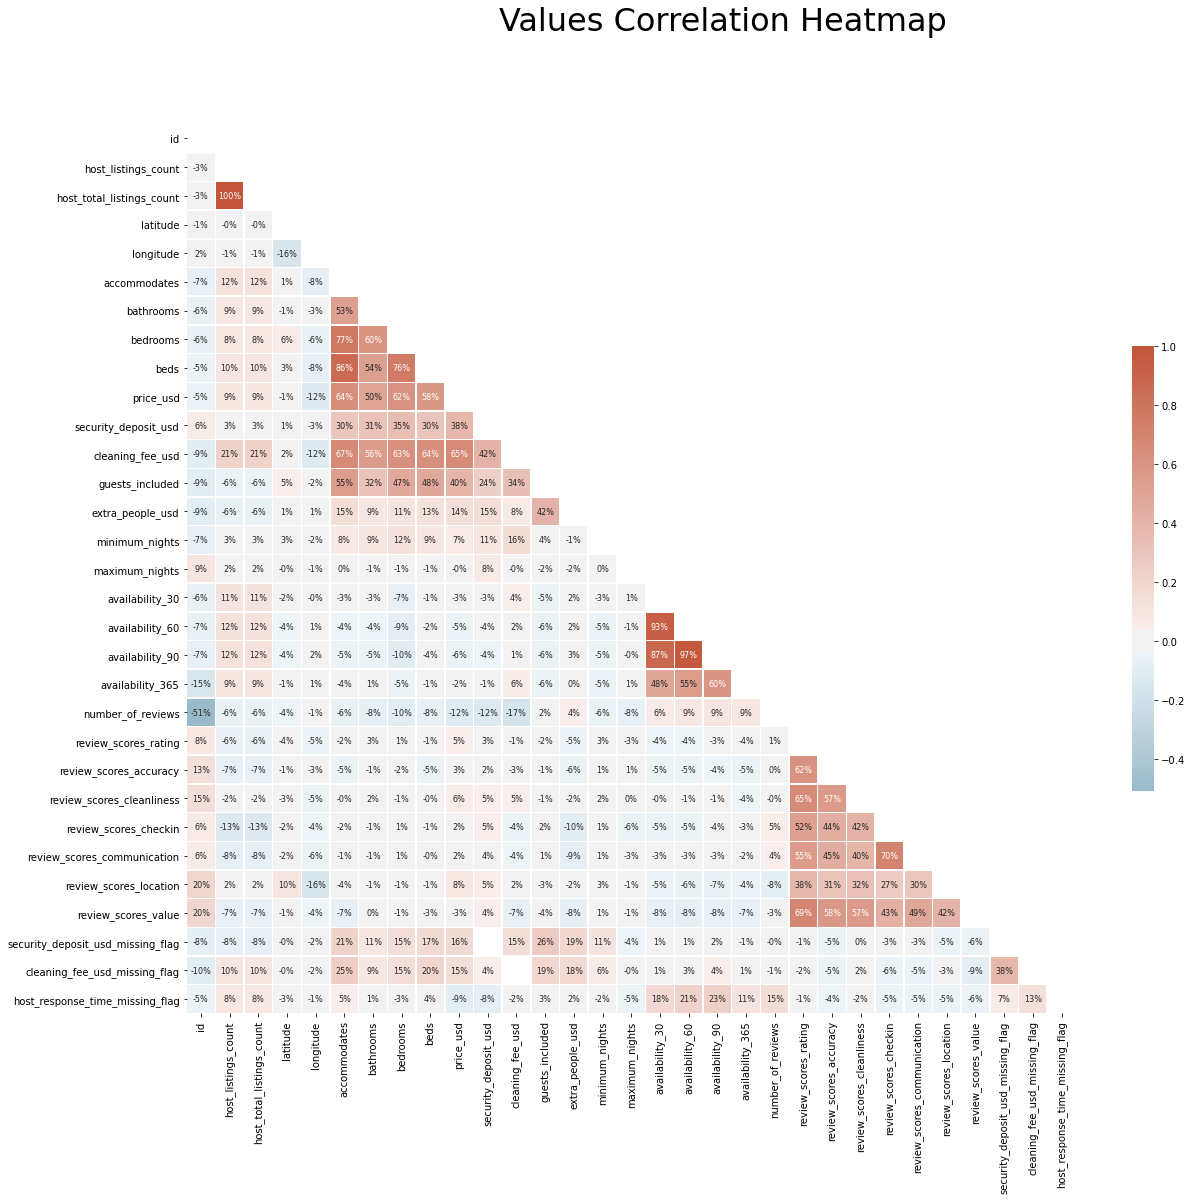

In [28]:
# Correlation visualization

# Compute the correlation matrix
corr = train_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 16.36))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True, fmt=".0%",
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={"fontsize":8})

f.suptitle('Values Correlation Heatmap', fontsize=32)

plt.show()

Correlation Notes:
* host_listings_count and host_total_listings_count are perfectly correlated. We can drop one and keep the other.
* Moderate to strong correlation between house space (bathrooms, bedrooms, beds, etc.) and number of people it accommodates. This is expected and serves as a good sanity check.
* Price is moderately correlated with house space and cleaning fee. Again, very much expected.
* Listing availability strongly correlates between adjacent periods (30/60/90/365 days). This is an intriguing situation, because it can imply that listings that are not in high demand now tend not to remain in low demand further - not counting for seasonality.
* Review scores have moderate correlations between each other, but with two interesting side-notes:
    * Overall score rating seems to correlates the most (in decreasing order) with: value, cleanliness and accuracy; and correlates least with location.
    * Communication and checking scores are also highly correlating - possibly indicating that communication is most important at checkin (if that goes well, all goes well).

#### Distribution Analysis

Moving onto distribution analysis, let's check how each of the features are distributed.  
This will be useful both in further analysis and when we start building a model - where some models require normal distribution.

C:\Users\gradi\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\gradi\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\gradi\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\gradi\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\gradi\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


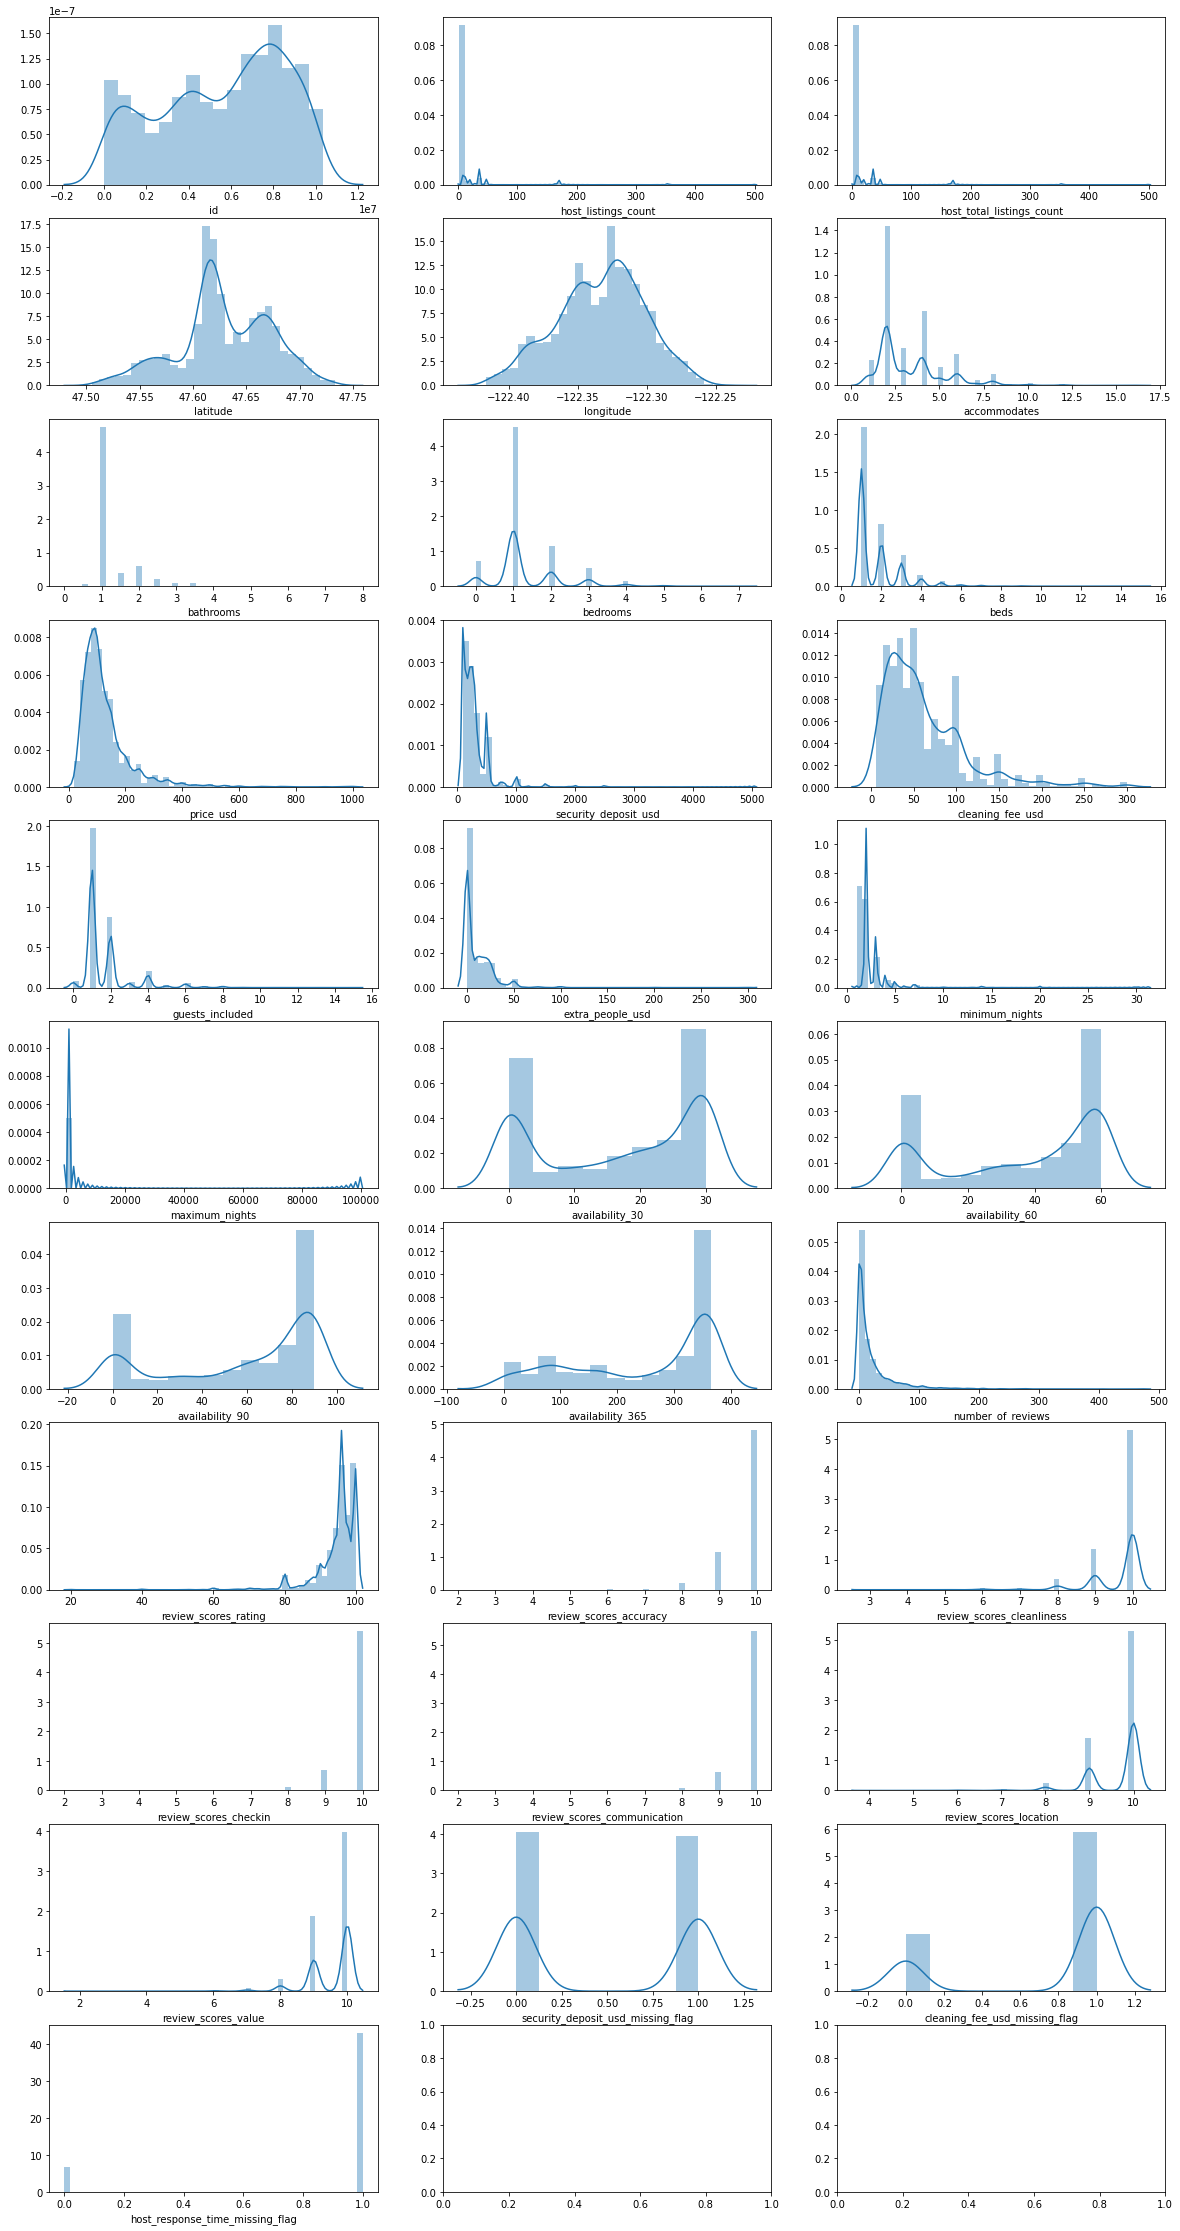

In [29]:
# Draw a grid of review column histograms
fig, axs = plt.subplots(11, 3, figsize=(20, 40))
axs = axs.flatten() # flatten to loop through

num_cols = train_df.select_dtypes(include=np.number).columns.tolist()

index = 0
for ax in axs:
    if index < len(num_cols):
        sns.distplot(train_df[num_cols[index]], hist=True, kde=True, label=num_cols[index], ax=ax)
        index += 1
        
plt.show() # show figures

That's interesting, but in order to use these columns (or one of them, as they seem highly correlated) we need a way to transform their distributions into normal ones.
We could apply the log transformation and see if the resulting data is normally ditributed.

#### Feature Engineering

We've seen from the previous article [(5 Things You Need to Know When Becoming an AirBnb Host in Seattle)](link.tbd) we may improve prediction power if we add distance from Seattle Center, as the distance from the center has an inverse relation to price (the closer to the center, the higher the price).

In [39]:
def distance_from_center(row):
    R = 6373.0 # earth's radius in km
    seattle_center = (47.6062, -122.3321) # Seattle center coordinates
    c_lat, c_lon = seattle_center
    c_lat = math.radians(c_lat)
    c_lon = math.radians(c_lon)
    
    lat = math.radians(row['latitude'])
    lon = math.radians(row['longitude'])
    
    dlon = lon - c_lon
    dlat = lat - c_lat
    
    a = (math.sin(dlat/2))**2 + math.cos(c_lat) * math.cos(lat) * (math.sin(dlon/2))**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = R * c
    
    return distance 

In [35]:
train_df['center_dist_km'] = train_df.apply(distance_from_center, axis=1)

Also, we have quite a few categorical columns we need to transform in order to include them in our model.
Specifically, we will take each variable, and either one-hot encode it (if the number of categories is small) and take them on a one-by-one basis otherwise.

In [59]:
obj_list = train_df[features].select_dtypes(include='object').columns

for col in obj_list:
    print('Column: {}; Categories: {}'.format(col,train_df[col].value_counts().size))

Column: property_type; Categories: 16
Column: room_type; Categories: 3
Column: bed_type; Categories: 5
Column: amenities; Categories: 2689
Column: cancellation_policy; Categories: 3


We can one-hot encode room_type, bed_type and cancellation_policy (5 or fewer categories), but we need to handle property_type and amenities differently. Let's take a look at the values in each column:

**property_type column:**

In [63]:
train_df['property_type'].sample(5)

3277        House
919         House
1203        House
316     Apartment
182     Apartment
Name: property_type, dtype: object

property_type column shows us exactly what it says - if a listing is an apartment, room, entire house, etc. This can also be indicated by the amount of people it can accommodate. Let's check if it's confirmed.

In [72]:
def compare_to_type(col_name):
    col_by_type = train_df[['property_type', col_name]].groupby(by=['property_type']).agg(np.mean)
    col_by_type = col_by_type.sort_values(by=[col_name],ascending=True).reset_index()
    sns.barplot(data=col_by_type, x='property_type', y=col_name)
    plt.xticks(rotation=65)
    plt.show()

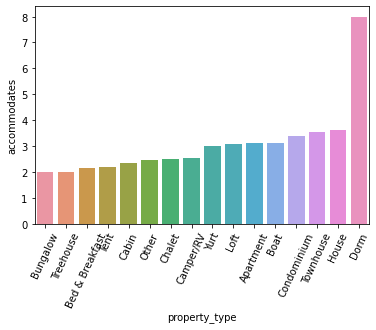

In [73]:
compare_to_type('accommodates')

It looks like there might be a relationship between the type and number of people it accommodates, so we could cluster types into 4-5 groups using KMeans, leveraging all columns indicative of size ('accommodates', 'bedrooms', 'bathrooms').  
We'll just skip this for now and revisit if we need to improve our model.

**amenities column:**

In [81]:
train_df['amenities'].sample(5)

3251    {TV,Internet,"Wireless Internet",Kitchen,"Free...
1777    {TV,Kitchen,Heating,"Smoke Detector","Carbon M...
82      {TV,"Cable TV",Internet,"Wireless Internet",Ki...
578     {"Wireless Internet",Kitchen,"Free Parking on ...
1460    {TV,Internet,"Wireless Internet","Air Conditio...
Name: amenities, dtype: object

These are full lists of amenities provided by the host. We will not parse and assess the importance of each one, but will simply count the number of amenities. This will be our feature for modelling.

In [82]:
train_df['amenities_count'] = train_df['amenities'].str.count(',') + 1

**one-hot encoding columns:**

In [86]:
onehot_cols = ['room_type', 'bed_type', 'cancellation_policy']

for onehot_col in onehot_cols:
    col_dummies = pd.get_dummies(train_df[onehot_col], prefix=onehot_col, drop_first=True)
    train_df = pd.concat([train_df, col_dummies], axis=1)
    train_df = train_df.drop([onehot_col], axis=1)

Now we have all the variable we want to create an initial model:  
`'room_type_Private room', 'room_type_Shared room'
 'accommodates',
 'bathrooms',
 'bedrooms',
 'bed_type_Couch', 'bed_type_Futon', 'bed_type_Pull-out Sofa', 'bed_type_Real Bed',
 'amenities_count',
 'guests_included',
 'minimum_nights', 'maximum_nights',
 'cancellation_policy_moderate', 'cancellation_policy_strict',
 'security_deposit_usd_missing_flag',
 'cleaning_fee_usd_missing_flag',
 'host_response_time_missing_flag',
 'center_dist_km'`

In [99]:
test_df = seattle_listings[relevant_cols].drop(train_df.index)

In [100]:
# Converting price columns to float
def clean_price(col):
    no_comma_price = col.str.replace(',', '')
    clean_price = no_comma_price.str.replace('$', '')
    return clean_price

price_cols = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']

test_df[price_cols] = test_df[price_cols].apply(clean_price, axis=0) # remove commas and currency symbols from price strings
test_df[price_cols] = test_df[price_cols].astype(float) # convert price values to float

# Rename price columns to indicat _usd in name
new_price_cols = []
for price_col in price_cols:
    new_col_name = price_col + '_usd'
    new_price_cols.append(new_col_name)

rename_dict = dict()
for old_name, new_name in zip(price_cols, new_price_cols):
    rename_dict[old_name] = new_name

test_df.rename(columns=rename_dict, inplace=True)

In [102]:
# Converting percentage columns to float
def clean_perc(col):
    no_perc_rate = col.str.replace('%', '')
    return no_perc_rate

rate_cols = ['host_acceptance_rate']

test_df[rate_cols] = test_df[rate_cols].apply(clean_perc, axis=0) # remove commas and currency symbols from price strings
test_df[rate_cols] = test_df[rate_cols].astype(float) / 100 # divide by 100 to get values bewtween 0 and 1

In [103]:
# create flag columns for features with meaning behind missing data
flag_cols = ['security_deposit_usd', 'cleaning_fee_usd', 'host_response_time']

for col in flag_cols:
    col_flag = col + '_missing_flag'
    test_df[col_flag] = 1 - test_df[col].isnull() * 1 # creates 1's for missing values and 0's for all other

In [105]:
# impute median values
median_cols = ['review_scores_checkin', 'review_scores_accuracy', 'review_scores_value', 'review_scores_location', \
               'review_scores_cleanliness', 'review_scores_communication', 'review_scores_rating', 'bathrooms', \
               'bedrooms', 'beds', 'host_listings_count', 'host_total_listings_count']

# multi column fillna not yet implemented
for col in median_cols:
    test_df[col] = test_df[col].fillna(test_df[col].median())

In [106]:
# get columns not in the flag column list and drop missing values for each
subset_cols = [col for col in test_df.columns if col not in flag_cols]
test_df.dropna(subset=subset_cols, inplace=True)

In [112]:
# calculate distance from center
test_df['center_dist_km'] = test_df.apply(distance_from_center, axis=1)

In [108]:
# count amenities
test_df['amenities_count'] = test_df['amenities'].str.count(',') + 1

In [110]:
# get one-hot encodings for categorical columns
onehot_cols = ['room_type', 'bed_type', 'cancellation_policy']

for onehot_col in onehot_cols:
    col_dummies = pd.get_dummies(test_df[onehot_col], prefix=onehot_col, drop_first=True)
    test_df = pd.concat([test_df, col_dummies], axis=1)
    test_df = test_df.drop([onehot_col], axis=1)

Test dataframe is ready.  
Let's build a model!

## **Building a Model**

#### **Linear Regression**

In [89]:
features = ['room_type_Private room', 'room_type_Shared room', 'accommodates', 'bathrooms',\
            'bedrooms', 'bed_type_Couch', 'bed_type_Futon', 'bed_type_Pull-out Sofa',\
            'bed_type_Real Bed', 'amenities_count', 'guests_included', 'minimum_nights',\
            'maximum_nights', 'cancellation_policy_moderate', 'cancellation_policy_strict',\
            'security_deposit_usd_missing_flag', 'cleaning_fee_usd_missing_flag',\
            'host_response_time_missing_flag', 'center_dist_km']

target = ['price_usd']

In [127]:
def fill_cols(df, cols):
    for feature in features:
        if feature not in df.columns:
            df.loc[:,feature] = 0
    return df

In [227]:
train_full_df = fill_cols(train_df, features) # to fill missing one-hot encoding columns
X_train = train_full_df[features]
y_train = train_df[target]

In [228]:
from sklearn.linear_model import LinearRegression

In [229]:
lr = LinearRegression()
lr_model = lr.fit(X_train, y_train)

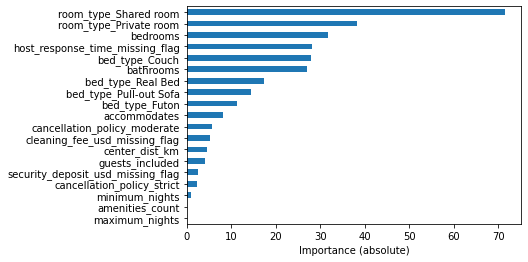

In [230]:
# get importance
importance = lr_model.coef_[0]
# summarize feature importance
feature_coefs = pd.Series(importance, index=X_train.columns)
feature_importance = np.abs(feature_coefs)
feature_importance = feature_importance.sort_values(ascending=True)
feature_importance.plot.barh()

plt.xlabel('Importance (absolute)')
plt.show()

In [231]:
lr_model.score(X_train, y_train)

0.5484169743872798

In [232]:
test_full_df = fill_cols(test_df, features) 
X_test = test_full_df[features]
y_test = test_df[target]

lr_model.score(X_test, y_test)

0.6481359018773003

In [233]:
preds = lr_model.predict(X_train)

In [235]:
preds_vs_actuals = y_train[:]
preds_vs_actuals['preds'] = preds

<ipython-input-235-45dd94db3efa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds_vs_actuals['preds'] = preds


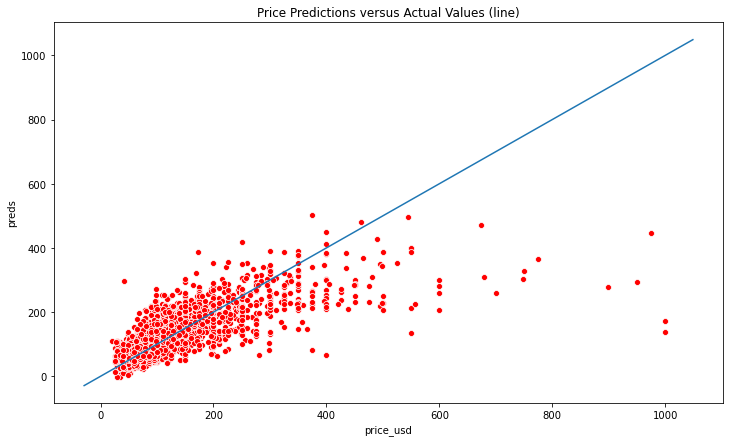

In [236]:
# plot line
fig, ax = plt.subplots(figsize = (12,7))

sns.scatterplot(data=preds_vs_actuals, x='price_usd', y='preds', color='red', ax=ax)

x = np.linspace(*ax.get_xlim())
ax.plot(x, x)

ax.set_title('Price Predictions versus Actual Values (line)')

plt.show()

This model is not extremely bad for low price listings (below \$400) but heavily undervalues higher priced listings.  
Not great, so let's try something else

#### **Random Forrest Regressor**

In [237]:
from sklearn.ensemble import RandomForestRegressor

In [238]:
rfr = RandomForestRegressor(random_state=42)
rfr_model = rfr.fit(X_train, y_train)

<ipython-input-238-294c2e28286f>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr_model = rfr.fit(X_train, y_train)


In [239]:
rfr_model.score(X_train, y_train)

0.9415518897567645

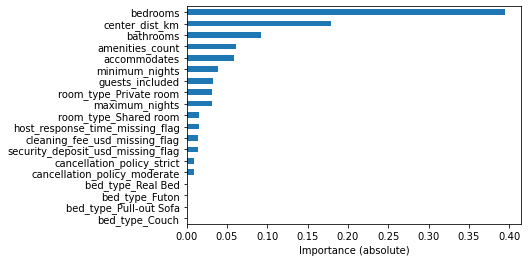

In [240]:
# get importance
importance = rfr_model.feature_importances_
# summarize feature importance
feature_coefs = pd.Series(importance, index=X_train.columns)
feature_importance = np.abs(feature_coefs)
feature_importance = feature_importance.sort_values(ascending=True)
feature_importance.plot.barh()

plt.xlabel('Importance (absolute)')
plt.show()

In [241]:
rfr_model.score(X_train, y_train)

0.9415518897567645

C:\Users\gradi\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\gradi\anaconda3\lib\site-packages\pandas\core\indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


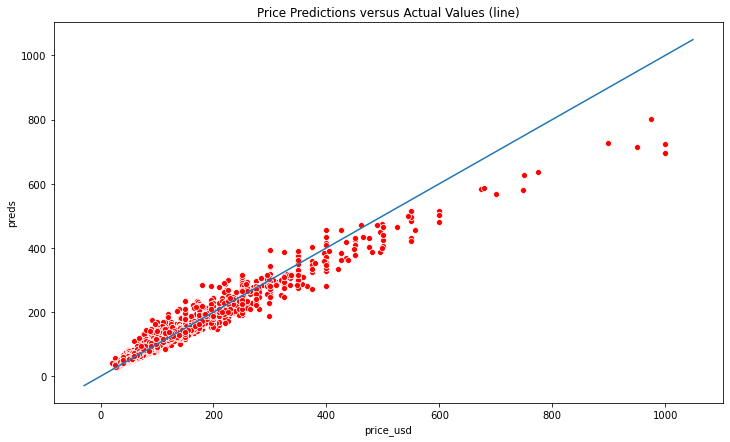

In [243]:
rfr_preds = rfr_model.predict(X_train)
rfr_preds_vs_actuals = y_train[:]
rfr_preds_vs_actuals.loc[:, 'preds'] = rfr_preds

# plot line
fig, ax = plt.subplots(figsize = (12,7))

sns.scatterplot(data=rfr_preds_vs_actuals, x='price_usd', y='preds', color='red', ax=ax)

x = np.linspace(*ax.get_xlim())
ax.plot(x, x)

ax.set_title('Price Predictions versus Actual Values (line)')

plt.show()

This model looks a lot better, and manages to handle high priced listings fairly well, with only a slight undervaluing compared to the linear regression.

In [244]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)  # Don't cheat - fit only on training data
X_train_scaled = scaler.transform(X_train)